In [113]:
import numpy as np
import torch
import torch.nn as nn
import lstm
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.metrics import mean_squared_error

In [114]:
df = pd.read_csv('tesla_flattened_data.csv')

In [115]:
df

,Date,Adj Close TSLA,Close TSLA,High TSLA,Low TSLA,Open TSLA,Volume TSLA
0,2020-01-02,28.684000,28.684000,28.713333,28.114000,28.299999,142981500
1,2020-01-03,29.534000,29.534000,30.266666,29.128000,29.366667,266677500
2,2020-01-06,30.102667,30.102667,30.104000,29.333332,29.364668,151995000
3,2020-01-07,31.270666,31.270666,31.441999,30.224001,30.760000,268231500
4,2020-01-08,32.809334,32.809334,33.232666,31.215334,31.580000,467164500
...,...,...,...,...,...,...,...
1001,2023-12-22,252.539993,252.539993,258.220001,251.369995,256.760010,93249800
1002,2023-12-26,256.609985,256.609985,257.970001,252.910004,254.490005,86892400
1003,2023-12-27,261.440002,261.440002,263.339996,257.519989,258.350006,106494400
1004,2023-12-28,253.179993,253.179993,265.130005,252.710007,263.660004,113619900


In [116]:
df[['Date','Close TSLA']]

,Date,Close TSLA
0,2020-01-02,28.684000
1,2020-01-03,29.534000
2,2020-01-06,30.102667
3,2020-01-07,31.270666
4,2020-01-08,32.809334
...,...,...
1001,2023-12-22,252.539993
1002,2023-12-26,256.609985
1003,2023-12-27,261.440002
1004,2023-12-28,253.179993


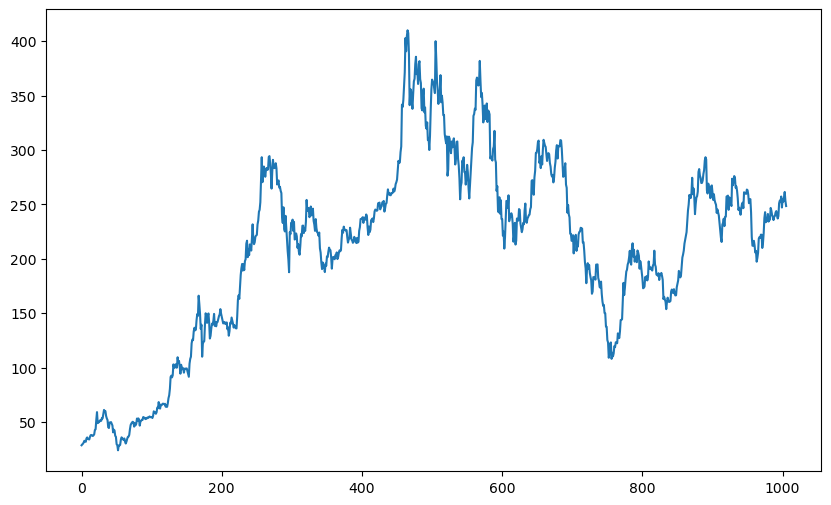

In [117]:
df['Close TSLA'].plot(figsize=(10, 6), subplots=True);

In [118]:
input_dim = 1
hidden_dim = 32
num_layers = 2 
output_dim = 1

In [119]:
model = lstm.LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

loss_fn = torch.nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)
10
torch.Size([128, 1])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([128, 32])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([1, 32])
torch.Size([1])


In [120]:
df=df.fillna(method='ffill')

scaler = MinMaxScaler(feature_range=(-1, 1))
df['Close TSLA'] = scaler.fit_transform(df['Close TSLA'].values.reshape(-1,1))
#df_ibm

In [121]:
def load_data(stock, look_back):
    data_raw = stock.values # convert to numpy array
    data = []
    
    # create all possible sequences of length look_back
    for index in range(len(data_raw) - look_back): 
        data.append(data_raw[index: index + look_back])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

look_back = 60 # choose sequence length
x_train, y_train, x_test, y_test = load_data(df[['Close TSLA']], look_back)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (757, 59, 1)
y_train.shape =  (757, 1)
x_test.shape =  (189, 59, 1)
y_test.shape =  (189, 1)


In [122]:
# make training and test sets in torch
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [123]:
# Train model
#####################
num_epochs = 200
hist = np.zeros(num_epochs)

# Number of steps to unroll
seq_dim =look_back-1  

for t in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #model.hidden = model.init_hidden()
    
    # Forward pass
    y_train_pred = model(x_train)

    loss = loss_fn(y_train_pred, y_train)
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimizer.step()


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


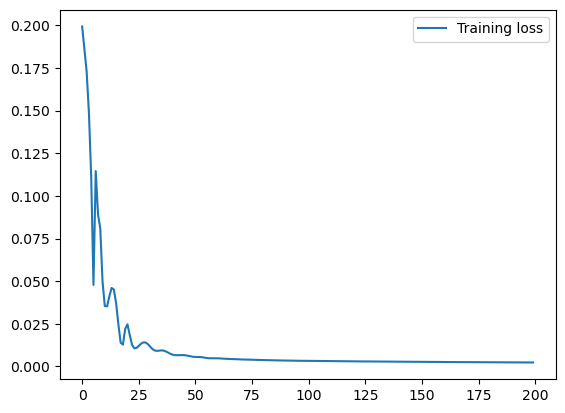

In [124]:
plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

In [125]:
# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 9.36 RMSE
Test Score: 7.58 RMSE


In [126]:
df

,Date,Adj Close TSLA,Close TSLA,High TSLA,Low TSLA,Open TSLA,Volume TSLA
0,2020-01-02,28.684000,-0.976145,28.713333,28.114000,28.299999,142981500
1,2020-01-03,29.534000,-0.971740,30.266666,29.128000,29.366667,266677500
2,2020-01-06,30.102667,-0.968792,30.104000,29.333332,29.364668,151995000
3,2020-01-07,31.270666,-0.962739,31.441999,30.224001,30.760000,268231500
4,2020-01-08,32.809334,-0.954764,33.232666,31.215334,31.580000,467164500
...,...,...,...,...,...,...,...
1001,2023-12-22,252.539993,0.184065,258.220001,251.369995,256.760010,93249800
1002,2023-12-26,256.609985,0.205159,257.970001,252.910004,254.490005,86892400
1003,2023-12-27,261.440002,0.230192,263.339996,257.519989,258.350006,106494400
1004,2023-12-28,253.179993,0.187382,265.130005,252.710007,263.660004,113619900


In [127]:
print(df)

            Date  Adj Close TSLA  Close TSLA   High TSLA    Low TSLA  \
0     2020-01-02       28.684000   -0.976145   28.713333   28.114000   
1     2020-01-03       29.534000   -0.971740   30.266666   29.128000   
2     2020-01-06       30.102667   -0.968792   30.104000   29.333332   
3     2020-01-07       31.270666   -0.962739   31.441999   30.224001   
4     2020-01-08       32.809334   -0.954764   33.232666   31.215334   
...          ...             ...         ...         ...         ...   
1001  2023-12-22      252.539993    0.184065  258.220001  251.369995   
1002  2023-12-26      256.609985    0.205159  257.970001  252.910004   
1003  2023-12-27      261.440002    0.230192  263.339996  257.519989   
1004  2023-12-28      253.179993    0.187382  265.130005  252.710007   
1005  2023-12-29      248.479996    0.163023  255.190002  247.429993   

       Open TSLA  Volume TSLA  
0      28.299999    142981500  
1      29.366667    266677500  
2      29.364668    151995000  
3      

In [128]:
import matplotlib.dates as mdates

[[195.28   ]
 [207.45999]
 [194.76999]
 [192.58   ]
 [185.52   ]
 [185.06   ]
 [184.51   ]
 [186.79   ]
 [180.54   ]
 [185.9    ]
 [185.     ]
 [187.04   ]
 [184.31   ]
 [180.59   ]
 [162.99   ]
 [165.08002]
 [162.55   ]
 [160.67   ]
 [153.75   ]
 [160.19   ]
 [164.31   ]
 [161.83   ]
 [160.31   ]
 [160.61   ]
 [161.2    ]
 [170.06   ]
 [171.79   ]
 [169.15   ]
 [168.54   ]
 [172.08   ]
 [167.98   ]
 [166.35   ]
 [166.52   ]
 [173.86   ]
 [176.89   ]
 [180.14   ]
 [188.87   ]
 [185.77   ]
 [182.9    ]
 [184.47   ]
 [193.17   ]
 [201.16   ]
 [203.93001]
 [207.52   ]
 [213.96999]
 [217.61   ]
 [221.31   ]
 [224.57   ]
 [234.86   ]
 [244.4    ]
 [249.83002]
 [258.71   ]
 [256.79   ]
 [255.90001]
 [260.54   ]
 [274.45   ]
 [259.46   ]
 [264.61   ]
 [256.6    ]
 [241.05   ]
 [250.21   ]
 [256.24   ]
 [257.5    ]
 [261.77   ]
 [279.82   ]
 [282.48   ]
 [276.54   ]
 [274.43   ]
 [269.61   ]
 [269.79   ]
 [271.99   ]
 [277.9    ]
 [281.38   ]
 [290.38   ]
 [293.34   ]
 [291.26   ]
 [262.9    ]

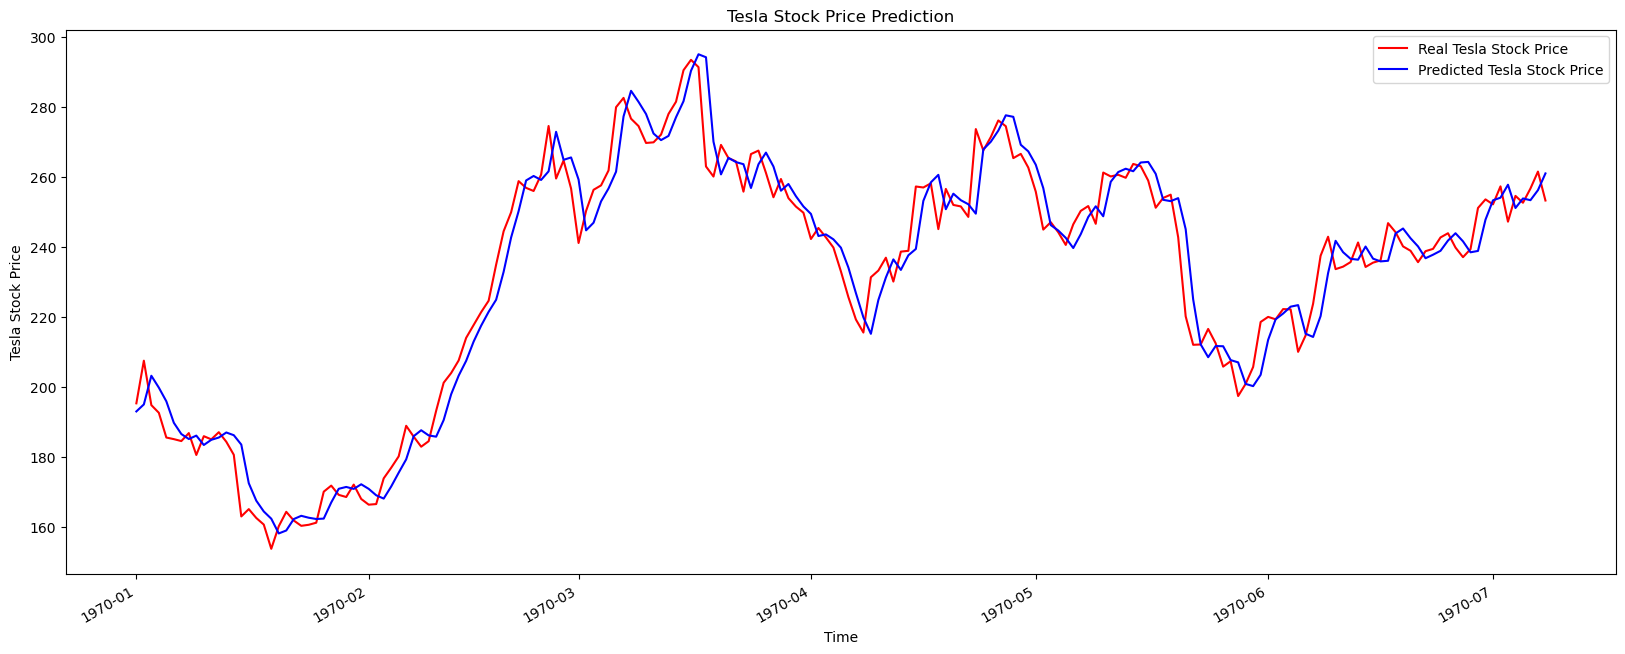

In [129]:
# Visualising the results
figure, axes = plt.subplots(figsize=(20, 8))
axes.xaxis_date()
# test_dates = df[len(df) - len(y_test):].index
print(y_test)  # If the index contains actual date strings
print(df[len(df['Close TSLA'])-len(y_test):]['Date'])

axes.plot(df[len(df['Close TSLA'])-len(y_test):]['Date'], y_test, color = 'red', label = 'Real Tesla Stock Price')
axes.plot(df[len(df['Close TSLA'])-len(y_test):]['Date'], y_test_pred, color = 'blue', label = 'Predicted Tesla Stock Price')
# Format x-axis for better readability
axes.xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Major ticks every month
axes.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format: Year-Month
figure.autofmt_xdate()  # Auto-rotate date labels
#axes.xticks(np.arange(0,394,50))
plt.title('Tesla Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Tesla Stock Price')
plt.legend()
#  plt.savefig('ibm_pred.png')
plt.show()

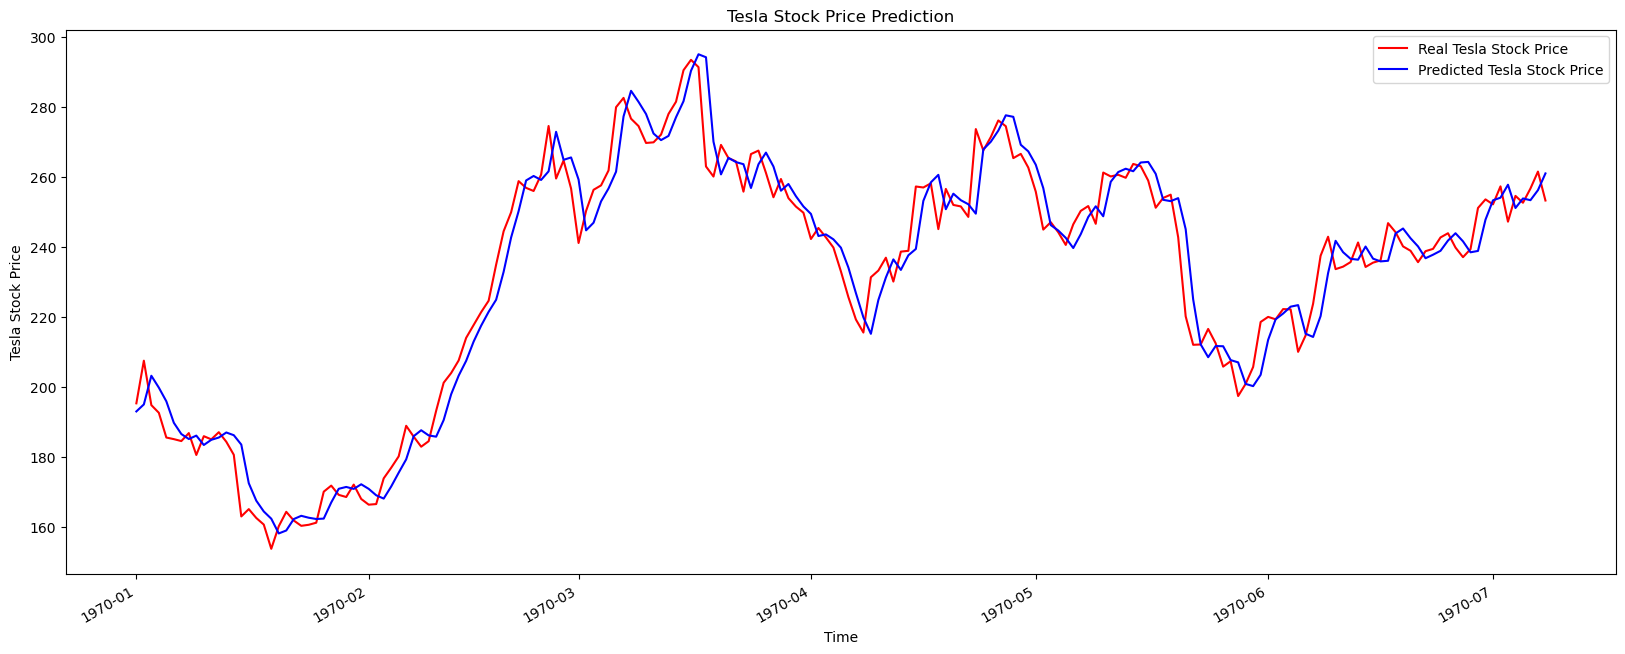

In [133]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

# Plot the data
figure, axes = plt.subplots(figsize=(20, 8))
axes.plot(df['Date'][-len(y_test):], y_test, color='red', label='Real Tesla Stock Price')
axes.plot(df['Date'][-len(y_test):], y_test_pred, color='blue', label='Predicted Tesla Stock Price')

# Format x-axis
axes.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
axes.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
figure.autofmt_xdate()

# Add titles and labels
plt.title('Tesla Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Tesla Stock Price')
plt.legend()
plt.show()


Test dates: 817    2023-03-31
818    2023-04-03
819    2023-04-04
820    2023-04-05
821    2023-04-06
          ...    
1001   2023-12-22
1002   2023-12-26
1003   2023-12-27
1004   2023-12-28
1005   2023-12-29
Name: Date, Length: 189, dtype: datetime64[ns]


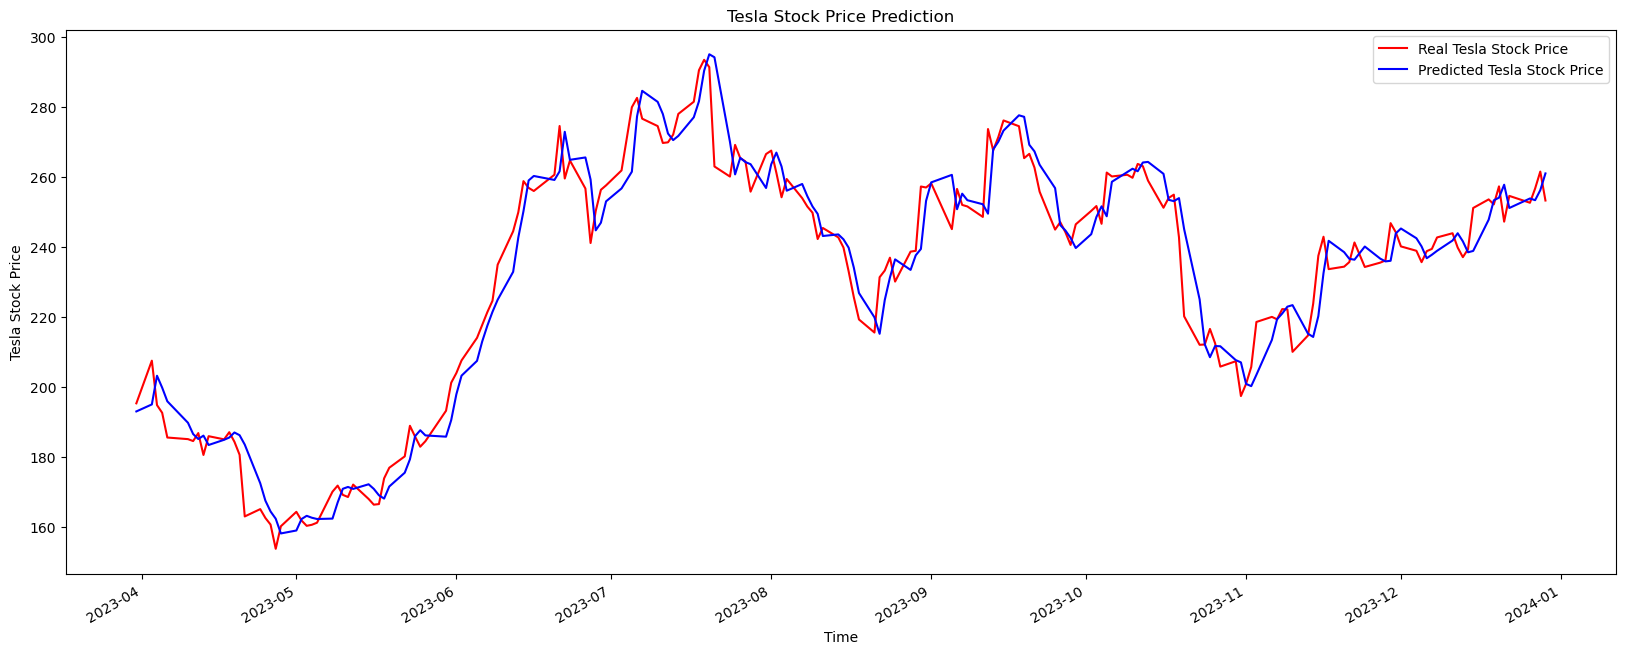

In [134]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

# Ensure Date is in datetime format
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
if df['Date'].isna().sum() > 0:
    print("Warning: Some dates could not be parsed. Check your data.")

# Align test dates
test_dates = df['Date'].iloc[-len(y_test):]
print("Test dates:", test_dates)

# Plot the data
figure, axes = plt.subplots(figsize=(20, 8))
axes.plot(test_dates, y_test, color='red', label='Real Tesla Stock Price')
axes.plot(test_dates, y_test_pred, color='blue', label='Predicted Tesla Stock Price')

# Format x-axis
axes.xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Major ticks every month
axes.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format: Year-Month
figure.autofmt_xdate()

# Add titles and labels
plt.title('Tesla Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Tesla Stock Price')
plt.legend()
plt.show()
